Описание/Пошаговая инструкция выполнения домашнего задания:
Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.


# Часть 1. Пишем симуляцию.

- Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. 
  - Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. 
  - На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. 
  - В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
- В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil
import pytz
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr



In [2]:
df = pd.read_csv('2008.csv')
df

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009723,2008,12,13,6,1002.0,959,1204.0,1150,DL,1636,...,6.0,45.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009724,2008,12,13,6,834.0,835,1021.0,1023,DL,1637,...,5.0,23.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009725,2008,12,13,6,655.0,700,856.0,856,DL,1638,...,24.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,1639,...,13.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [5]:
# Честно уперто с просторов интернета
airport_tz = pd.read_fwf('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', names=['code', 'tz'], colspecs=[(0, 3), (3, None)])
#
# make sure that all airports in our dataset are present
airports =  set(df['Origin']).union(set(df['Dest']))
codes = airport_tz.code.unique()
tz_dict = {row.code: row.tz for row in airport_tz.itertuples()}

In [18]:
def convert_date(year, month, day, time, airport):
    time = str(int(time)).rjust(4, '0')
    H = int(time[:2])
    M = int(time[2:])
    if H==24:
        H=23
        M=59
    tz = dateutil.tz.gettz(tz_dict[airport])
    
    return datetime.datetime(year, month, day, H, M, tzinfo=tz).astimezone(pytz.utc)

In [17]:
df['DepTime'].unique()

array([2003.,  754.,  628., ...,  343.,  342.,  344.], shape=(1440,))

In [14]:
df.drop(df[df['Cancelled'] == 1].index, inplace=True)
df.drop(df[df['Diverted'] == 1].index, inplace=True)


In [19]:
df['Dep'] = df.apply(lambda x: convert_date(x['Year'], x['Month'], x['DayofMonth'], x['DepTime'], x['Origin']), axis=1)

In [20]:
df['Arr'] = df.apply(lambda x: convert_date(x['Year'], x['Month'], x['DayofMonth'], x['ArrTime'], x['Dest']), axis=1)

In [21]:
# Исправляем ночные перелеты
df.loc[df['Dep'] > df['Arr'], 'Arr'] += datetime.timedelta(hours=24)


In [22]:
flights = df[['Dep', 'Origin', 'Arr', 'Dest']].sort_values('Dep')
flights

,Dep,Origin,Arr,Dest
354001,2008-01-01 05:02:00+00:00,ATL,2008-01-01 05:57:00+00:00,CHS
115630,2008-01-01 05:03:00+00:00,CLE,2008-01-01 08:30:00+00:00,SAT
129414,2008-01-01 05:05:00+00:00,IAD,2008-01-01 06:32:00+00:00,CLE
546586,2008-01-01 05:08:00+00:00,JFK,2008-01-01 08:32:00+00:00,PBI
453677,2008-01-01 05:09:00+00:00,CVG,2008-01-01 07:15:00+00:00,MHT
...,...,...,...,...
6729466,2009-01-01 09:39:00+00:00,HNL,2009-01-01 16:05:00+00:00,PHX
6662779,2009-01-01 09:41:00+00:00,OGG,2009-01-01 16:42:00+00:00,DEN
6663392,2009-01-01 09:50:00+00:00,HNL,2009-01-01 15:37:00+00:00,LAX
6729467,2009-01-01 09:57:00+00:00,HNL,2009-01-01 16:13:00+00:00,PHX


# Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

In [23]:
airports = set(airports)
airports_count = len(airports)

In [24]:
def simulation(p, date = '2008-01-01', airport = 'IAD'):
    date = datetime.datetime.strptime(date + ' +00:00', '%Y-%m-%d %z').astimezone(pytz.utc)
    select = flights[flights['Dep'] >= date]
    infected = {airport: pd.Timestamp(date)}
    for col in tqdm(select.itertuples()):
        if col.Origin in infected.keys():
            # Проверяем, что время вылета не позже времени заражения
            if col.Dep <= infected[col.Origin]:
                continue
            # Проверяем, что аэропорт назначения не заражен
            if col.Dest in infected.keys():
                continue
            if np.random.rand() > p:
                continue
            infected[col.Dest] = col.Arr
            if len(infected) == airports_count:
                break
    return {v: k for k, v in infected.items()}



In [25]:
sim_result = {}
for p in [0.01, 0.05, 0.1, 0.5, 1]:
    results = []
    for i in range(10):
        result = simulation(p)
        results.append(result)
    sim_result[p] = results


6855029it [00:06, 1073542.73it/s]
6855029it [00:05, 1286266.26it/s]
6855029it [00:05, 1268403.39it/s]
6855029it [00:05, 1275639.24it/s]
6855029it [00:05, 1274064.76it/s]
6855029it [00:05, 1274136.24it/s]
6855029it [00:05, 1286597.56it/s]
6855029it [00:05, 1272606.36it/s]
6855029it [00:05, 1288779.34it/s]
6855029it [00:05, 1282572.91it/s]
6855029it [00:05, 1274556.46it/s]
6855029it [00:05, 1284776.47it/s]
6855029it [00:05, 1281499.40it/s]
6855029it [00:05, 1266806.86it/s]
6855029it [00:05, 1254857.23it/s]
6855029it [00:05, 1246923.22it/s]
6855029it [00:05, 1265066.87it/s]
6855029it [00:05, 1272485.71it/s]
6855029it [00:05, 1259304.79it/s]
6855029it [00:05, 1271790.58it/s]
6855029it [00:05, 1254889.87it/s]
6855029it [00:05, 1250201.84it/s]
6855029it [00:05, 1260623.63it/s]
6855029it [00:05, 1253882.86it/s]
6855029it [00:05, 1272520.86it/s]
6855029it [00:05, 1243289.61it/s]
6855029it [00:05, 1254439.05it/s]
6855029it [00:05, 1233014.70it/s]
6855029it [00:05, 1260703.56it/s]
6855029it [00:

In [26]:
start = pd.Timestamp('2008-01-01', tz='UTC')
interval = pd.Timedelta(hours=12)

res_dict = {}

for p, sim_list in sim_result.items():
    # вычисляем максимальный номер интервала для всех прогонов
    full_max_interval = max([
        ((pd.Series(list(sim.keys())).astype('int64') - start.value) // interval.value).max()
        for sim in sim_list
    ])
    full_intervals = np.arange(0, full_max_interval + 1)
    interval_counts_cum = []
    for sim in sim_list:
        timestamps = list(sim.keys())
        interval_nums = ((pd.Series(timestamps).astype('int64') - start.value) // interval.value)
        counts = interval_nums.value_counts().sort_index()
        # все интервалы с момента старта, заполняем отсутствующие
        counts_all = counts.reindex(full_intervals, fill_value=0)
        cum_all = counts_all.cumsum()
        interval_counts_cum.append(cum_all)
    # собираем DataFrame по интервалу (строки — интервалы, столбцы — симуляции)
    df = pd.DataFrame(interval_counts_cum).T.fillna(0).astype(int)
    # считаем статистику
    stats = pd.DataFrame({
        'min': df.min(axis=1),
        'max': df.max(axis=1),
        'mean': df.mean(axis=1)
    })
    # номер интервала явно, с 0
    stats['interval_number'] = stats.index
    # можно добавить отображение начала интервала в timestamp
    stats['interval_start'] = start + stats['interval_number'] * interval
    # индекс по номеру интервала (для логарифмических графиков использовать interval_number)
    stats = stats.set_index('interval_number')
    res_dict[p] = stats


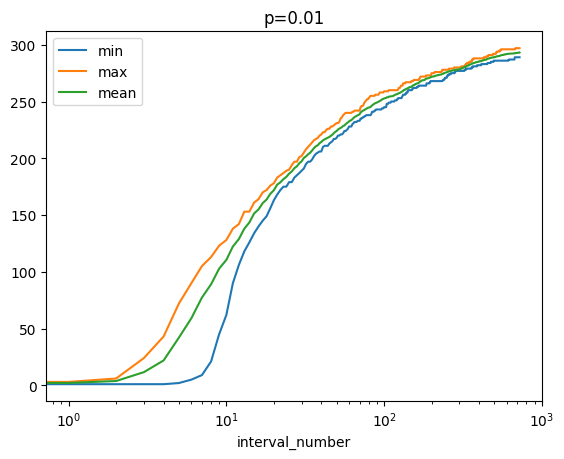

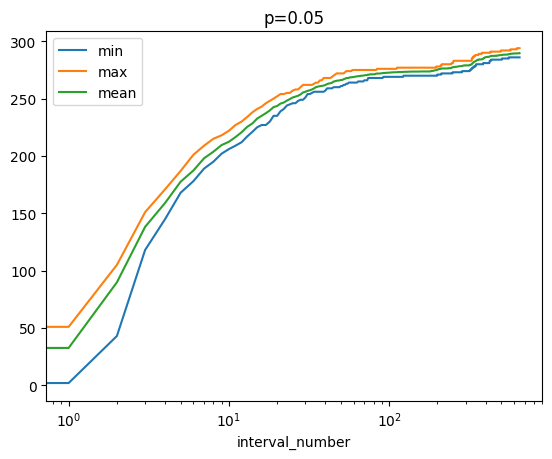

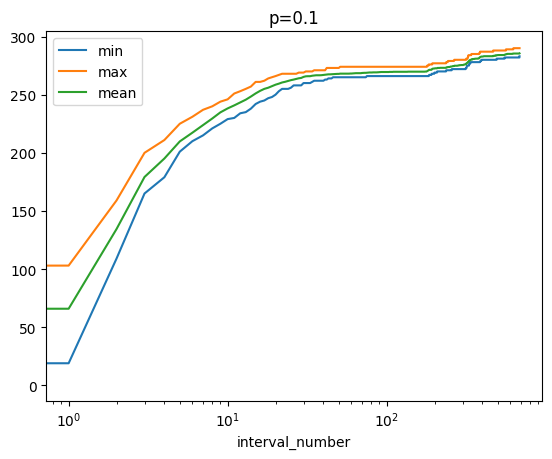

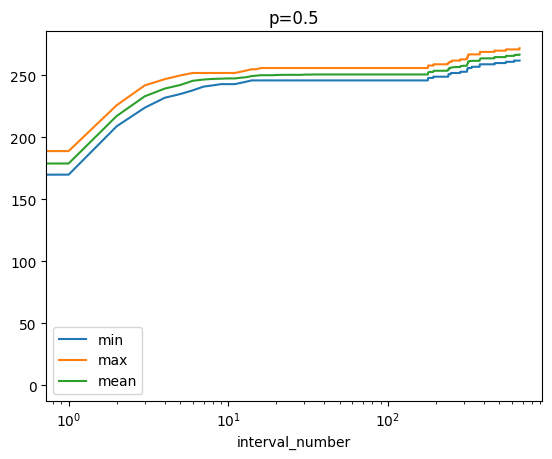

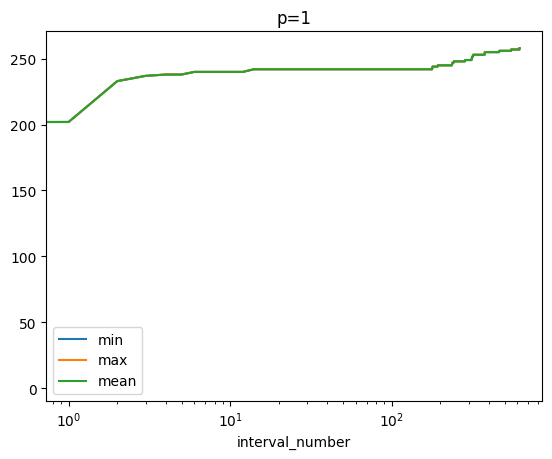

In [27]:
for p in res_dict.keys():
    res_dict[p].drop('interval_start', axis=1).plot(logx=True, title=f'p={p}')

# Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

Настало время поработать с NetworkX. 
- По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. 
  - Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
- Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
- Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
- Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. 
- Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. 
- Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

In [28]:
flight_counts = flights.groupby(['Origin', 'Dest']).size().reset_index(name='count')
flight_counts

,Origin,Dest,count
0,ABE,ATL,835
1,ABE,BHM,1
2,ABE,CLE,791
3,ABE,CLT,457
4,ABE,CVG,243
...,...,...,...
5195,YUM,IPL,323
5196,YUM,LAS,95
5197,YUM,LAX,1037
5198,YUM,PHX,1887


In [29]:
flight_counts['pair'] = flight_counts.apply(lambda x: frozenset([x['Origin'], x['Dest']]), axis=1)
edges = flight_counts.groupby('pair')['count'].sum().reset_index()

In [30]:
edges

,pair,count
0,"(ATL, ABE)",1677
1,"(MOB, IAH)",2738
2,"(IAH, MSP)",4829
3,"(IAH, MSY)",8297
4,"(MTJ, IAH)",511
...,...,...
2678,"(CMH, MDW)",5198
2679,"(CMH, MEM)",2086
2680,"(CMH, MIA)",921
2681,"(CMH, MSP)",2132


In [31]:
G = nx.Graph()

In [32]:
total_flights = df.shape[0]
for idx, row in edges.iterrows():
    airports = tuple(row['pair'])
    weight = row['count']/total_flights
    G.add_edge(airports[0], airports[1],  weight=weight)

In [33]:
print("Число узлов:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())
print("Вес ребра JFK-LAX:", G['JFK']['LAX']['weight'])

Число узлов: 303
Число рёбер: 2683
Вес ребра JFK-LAX: 25.551612903225806


In [34]:
def simulate_spread(graph=G, start='IAD', p=0.5):
    # infected — множество аэропортов, которые уже заражены
    infected = set([start])
    # times — словарь: сколько шагов прошло до заражения каждого аэропорта
    times = {start: 0}
    step = 0          
    queue = [start]   # список только что заражённых на предыдущем шаге

    while queue:
        next_queue = []   # список, кто заразится на этом шаге
        step += 1     # увеличиваем номер шага
        for airport in queue:
            for neighbor in graph.neighbors(airport):
                if neighbor not in infected:
                    # случайно решаем — заразится или нет (вероятность p)
                    if np.random.rand() < p:
                        infected.add(neighbor)
                        times[neighbor] = step
                        next_queue.append(neighbor)
        queue = next_queue    # переходим к вновь заражённым на новом шаге

    # на выход — словарь "аэропорт: время заражения"
    return times


In [35]:
results = []
for _ in range(50):
    infection_times = simulate_spread(p=0.5)
    results.append(infection_times)


In [36]:
all_airports = list(G.nodes)
median_times = {}

for airport in all_airports:
    times = [run.get(airport, None) for run in results]
    times_filtered = [t for t in times if t is not None]
    median_times[airport] = np.median(times_filtered) if times_filtered else np.nan


In [37]:
clustering = nx.clustering(G)
clustering

{'ATL': 0.13899717703992473,
 'ABE': 0.8363636363636363,
 'MOB': 1.0,
 'IAH': 0.25710293432696785,
 'MSP': 0.21193650793650792,
 'MSY': 0.7975609756097561,
 'MTJ': 1.0,
 'OAK': 0.6723484848484849,
 'OKC': 0.7806451612903226,
 'OMA': 0.7948717948717948,
 'MLU': 1.0,
 'ONT': 0.6515151515151515,
 'ORF': 0.7839080459770115,
 'PBI': 0.7962962962962963,
 'PDX': 0.5539112050739958,
 'PHL': 0.6288720046756283,
 'PHX': 0.3709508881922675,
 'PIT': 0.7984126984126985,
 'PNS': 1.0,
 'ORD': 0.17825503355704697,
 'MKE': 0.5918367346938775,
 'MIA': 0.6913265306122449,
 'MGM': 1.0,
 'JAN': 0.8333333333333334,
 'JAX': 0.75,
 'JFK': 0.41784037558685444,
 'LAS': 0.37045177045177047,
 'LAX': 0.3388661899897855,
 'LBB': 0.9047619047619048,
 'LCH': 0,
 'LEX': 0.8285714285714286,
 'LFT': 1.0,
 'LGA': 0.38414918414918414,
 'LIT': 0.861904761904762,
 'LRD': 1.0,
 'MAF': 0.9047619047619048,
 'MCI': 0.6334841628959276,
 'MCO': 0.3667915106117353,
 'MEM': 0.37065887698799094,
 'MFE': 1.0,
 'PSP': 1.0,
 'RDU': 0.7

In [38]:
degree = dict(G.degree())
degree


{'ATL': 173,
 'ABE': 11,
 'MOB': 5,
 'IAH': 114,
 'MSP': 126,
 'MSY': 41,
 'MTJ': 8,
 'OAK': 33,
 'OKC': 31,
 'OMA': 27,
 'MLU': 3,
 'ONT': 33,
 'ORF': 30,
 'PBI': 28,
 'PDX': 44,
 'PHL': 59,
 'PHX': 88,
 'PIT': 36,
 'PNS': 9,
 'ORD': 150,
 'MKE': 50,
 'MIA': 49,
 'MGM': 3,
 'JAN': 13,
 'JAX': 40,
 'JFK': 72,
 'LAS': 91,
 'LAX': 89,
 'LBB': 7,
 'LCH': 1,
 'LEX': 15,
 'LFT': 3,
 'LGA': 66,
 'LIT': 21,
 'LRD': 2,
 'MAF': 7,
 'MCI': 52,
 'MCO': 90,
 'MEM': 79,
 'MFE': 3,
 'PSP': 12,
 'RDU': 45,
 'RIC': 22,
 'RNO': 23,
 'XNA': 21,
 'ICT': 15,
 'CID': 11,
 'SLC': 111,
 'IDA': 3,
 'ILM': 5,
 'IND': 39,
 'VPS': 7,
 'TYS': 15,
 'TUL': 30,
 'RSW': 35,
 'SAN': 55,
 'SAT': 41,
 'SAV': 17,
 'SDF': 29,
 'SEA': 56,
 'SFO': 70,
 'SHV': 6,
 'SJC': 28,
 'SJU': 23,
 'SMF': 37,
 'SNA': 26,
 'SRQ': 16,
 'STL': 51,
 'TLH': 8,
 'TPA': 63,
 'TUS': 32,
 'HOU': 33,
 'AGS': 4,
 'HPN': 12,
 'HRL': 5,
 'IAD': 71,
 'HSV': 15,
 'DCA': 56,
 'EWR': 91,
 'MDW': 54,
 'ROC': 16,
 'SPI': 3,
 'STT': 12,
 'SYR': 15,
 'ROA'

In [39]:
betweenness = nx.betweenness_centrality(G)
betweenness


{'ATL': 0.20517914327490666,
 'ABE': 0.00011385145000176037,
 'MOB': 0.0,
 'IAH': 0.061004741798816854,
 'MSP': 0.10495293820649684,
 'MSY': 0.0006382848818134165,
 'MTJ': 0.0,
 'OAK': 0.0007687198691590243,
 'OKC': 0.0006205719014098625,
 'OMA': 0.000386155427207604,
 'MLU': 0.0,
 'ONT': 0.0008330662611093604,
 'ORF': 0.00019329552443260253,
 'PBI': 0.00041244183363902575,
 'PDX': 0.00899361756900109,
 'PHL': 0.002234856901253733,
 'PHX': 0.03142138854858838,
 'PIT': 0.002374434258879329,
 'PNS': 0.0,
 'ORD': 0.08804062433722841,
 'MKE': 0.007694647133364125,
 'MIA': 0.002131773501792316,
 'MGM': 0.0,
 'JAN': 2.6621152087670316e-05,
 'JAX': 0.0022719236300782638,
 'JFK': 0.012685303676473912,
 'LAS': 0.01926225479112386,
 'LAX': 0.050814522637580066,
 'LBB': 1.7349650335230064e-05,
 'LCH': 0.0,
 'LEX': 0.0001000564441037271,
 'LFT': 0.0,
 'LGA': 0.008506648234264159,
 'LIT': 0.00022057829304788622,
 'LRD': 0.0,
 'MAF': 1.7349650335230064e-05,
 'MCI': 0.002106579138284567,
 'MCO': 0.01

In [40]:
df = pd.DataFrame({
    'airport': list(median_times.keys()),
    'median_time': [median_times[ap] for ap in median_times],
    'clustering': [clustering[ap] for ap in median_times],
    'degree': [degree[ap] for ap in median_times],
    'betweenness': [betweenness[ap] for ap in median_times]
})
df


,airport,median_time,clustering,degree,betweenness
0,ATL,2.0,0.138997,173,0.205179
1,ABE,2.0,0.836364,11,0.000114
2,MOB,2.0,1.000000,5,0.000000
3,IAH,2.0,0.257103,114,0.061005
4,MSP,1.0,0.211937,126,0.104953
...,...,...,...,...,...
298,CPR,2.0,1.000000,4,0.000000
299,HTS,2.0,0.000000,1,0.000000
300,CMI,2.0,0.666667,3,0.000110
301,CMX,2.0,0.000000,1,0.000000


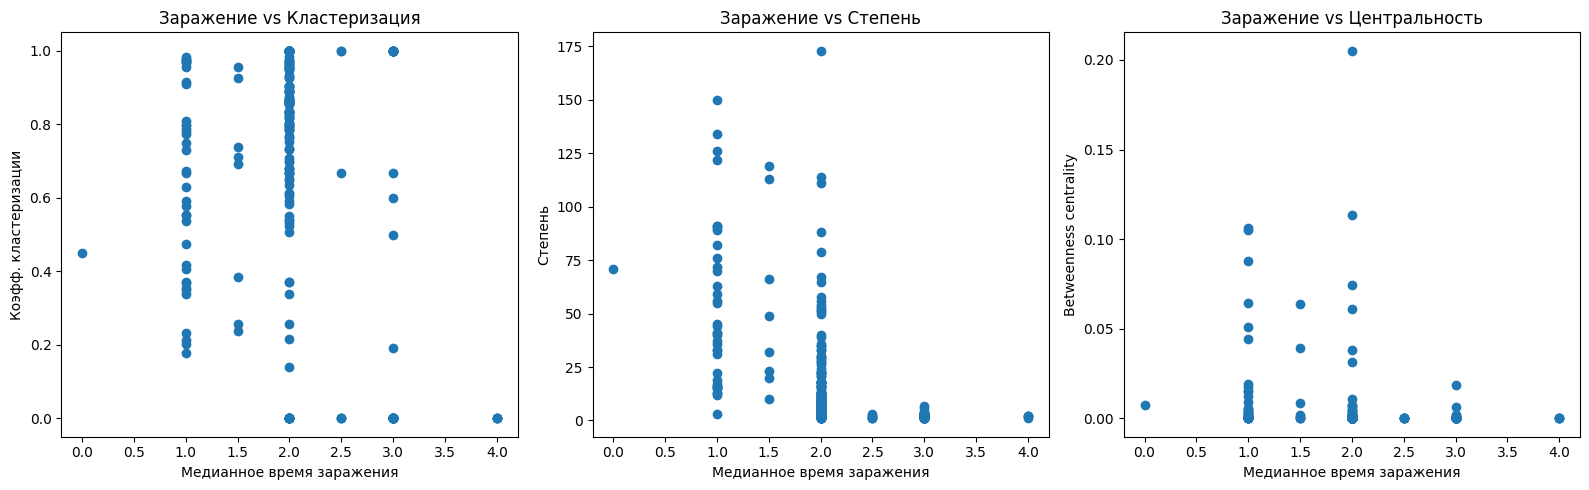

In [41]:
plt.figure(figsize=(16,5))

# 1. Медианное время vs Кластеризация
plt.subplot(1,3,1)
plt.scatter(df['median_time'], df['clustering'])
plt.xlabel('Медианное время заражения')
plt.ylabel('Коэфф. кластеризации')
plt.title('Заражение vs Кластеризация')

# 2. Медианное время vs Степень
plt.subplot(1,3,2)
plt.scatter(df['median_time'], df['degree'])
plt.xlabel('Медианное время заражения')
plt.ylabel('Степень')
plt.title('Заражение vs Степень')

# 3. Медианное время vs Betweenness centrality
plt.subplot(1,3,3)
plt.scatter(df['median_time'], df['betweenness'])
plt.xlabel('Медианное время заражения')
plt.ylabel('Betweenness centrality')
plt.title('Заражение vs Центральность')

plt.tight_layout()
plt.show()


In [29]:
coef_c, pval_c = spearmanr(df['median_time'], df['clustering'])
coef_d, pval_d = spearmanr(df['median_time'], df['degree'])
coef_b, pval_b = spearmanr(df['median_time'], df['betweenness'])

print(f'Кластеризация: корреляция {coef_c:.3f} (p={pval_c:.3g})')
print(f'Степень: корреляция {coef_d:.3f} (p={pval_d:.3g})')
print(f'Betweenness: корреляция {coef_b:.3f} (p={pval_b:.3g})')


Кластеризация: корреляция 0.021 (p=0.719)
Степень: корреляция -0.598 (p=5.23e-31)
Betweenness: корреляция -0.461 (p=1.74e-17)


Ожидаемо самое большое влияние оказывает количество соседей